In [20]:
# 此部分海带的模拟的核心代码(状态向量和转移矩阵的构造)是由chen_yu_xuan编写的，以下是他的个人主页链接
# https://space.bilibili.com/67131398
# 由于我的方法运行程序的效率过低(我的原始方案在参考资料里有)，故采推荐使用chen_yu_xuan给出的算法方案
# 其余的画图是我和ai来回改的n手代码(n>=10)
# v2是我新的优化的代码，主要就是让矩阵大小和限高匹配以减少运算量提高运算速度

import math
import numpy as np #基础库科学运算
import matplotlib.pyplot as plt # 画图
from matplotlib.ticker import MultipleLocator
import pandas as pd # 导出表格

# 1.1 条件参数
时间表 = list(range(1, 1+72000, 1)) # 时间数组，从1~72000tick遍历一遍每个时间节点的数据
产量放大系数 = 72000 # 算出来的数据时间单位都是tick，所以数值非常小，可以放大72000被得到每小时的效率

p = 0.14 # 每次随机刻选中后生长的概率。海带=0.14，垂泪藤/缠怨藤=0.1，发光浆果(洞穴藤蔓)=0.1
最大高度 = 25 #不包括根部的最大高度！也就是当最大高度时，根部上面的部分高度。截止1.21所有的植物都填写25(长到最高后总高度为26)
限高列表 = list(range(1, 1+最大高度, 1)) # 列出想看的限高情况，推荐只看看[1,2,3,4,5]的高度就行了，实际上最后发现还是矮的限高比较好(单位效率和单位体积效率都高)

收割费时 = 4 # 收割造成的时间损耗。对于被侦测器激活的活塞：水生植物为4(水流补充耗时为5-0-1=4)，空气中的植物为2(侦测器+活塞)或4(二挡中继器+粘液棒)；0t活塞收割，空气中的植物为0
公摊高度 = 2 # 每个海带除了自己生长的必要空间其余的高度方面的体积(例如不能收割的海带根与其种植的方块)

# 1.2 输出相关参数
图片像素尺寸 = 2160 # 单个图像的像素大小(边长)，这三个图像会拼成一个整图输出
标记极值的限高表_单位产量图 = []
标记极值的限高表_单位效率图 = [1,2]
标记极值的限高表_单位体积效率图 = [1,2,3,4]



# 2. 计算
单位产量表 = []
单位效率表 = []
单位体积效率表 = []
for 当前限高 in 限高列表: # 对于每一个限高

    # 2.1 定义状态转移矩阵：
    # 过程是不断地尝试往左上角转移，到左上角的终态(可以生长的高度耗尽)
    # 第一行表示可生长高度为0，第i+1行表示可生长高度为i，每一次向左上角转移表示生长了一次，对应的可生长高度也被消耗了一次
    # 主对角线第一个元素为1表示这个是吸收态，到达这个状态意味着天生的可生长高度耗尽了，无法继续生长了
    P = np.zeros((当前限高+2,当前限高+2))
    P[0,0]=1 #吸收态(耗尽可生长高度)
    for i in range(当前限高):
        P[i+1,i+1] = 1-p/4096 # 每tick不变的概率
        P[i+1,i] = p/4096 # 每tick变化的概率
        P[i+1,-1] = p/4096 # 最后一列是产量，每个状态乘生长的概率(p/4096)就是当前tick这个状态的百分比对产量的贡献，由于矩阵乘法的性质会导致求和，最后就是S[-1]就会不断累计每个tick下的产量。
    P[-1,-1] = 1 #每次状态转移保持上一次的产量不变
    P_3t = np.linalg.matrix_power(P, 3) # 3次方矩阵，即1tick内三次随机刻的状态转移矩阵

    # 2.2 生成该限高下的初始状态概率矩阵
    A = np.zeros(当前限高+1+1) # 在最后有额外一个表示产量的数
    for 随机可生长高度 in range(1,最大高度+1):
        A[min(当前限高, 随机可生长高度)] += 1 / 最大高度
    S = A
    
    # 2.3 计算每个时间下的状态概率
    单位产量表_限高=[]
    单位效率表_限高=[]
    单位体积效率表_限高=[]
    for t in 时间表: 
        # 下面两个S的表达式，一个是直接n次方算，一个是反复累乘，两者是等价的，
        # 前者精度高但是速度慢(4秒 VS 100秒)，后者速度快但是精度低一点。请二选一，把另一个屏蔽掉(用#转化为注释)
        
        S = A @ np.linalg.matrix_power(P, 3*t) # 高精度，速度慢
        #S = S @ P_3t # 速度快，精度低一点点，只适用于range(1,n+1,1)的情况，其他情况需要做出修改

        单位产量 = S[-1]
        单位产量表_限高.append(float(单位产量))
        单位效率表_限高.append(float(产量放大系数 * 单位产量 / (t + 收割费时)))
        单位体积效率表_限高.append(float(产量放大系数 * 单位产量 / (t + 收割费时) / (当前限高 + 公摊高度)))
    print(f"限高={当前限高}的数据计算完成")
    # 遍历完所有时间后汇总每个限高的数据，所有限高穷举完之后得到完整的表
    单位产量表.append(单位产量表_限高)
    单位效率表.append(单位效率表_限高)
    单位体积效率表.append(单位体积效率表_限高)
print("全部数据计算完成")


限高=1的数据计算完成
限高=2的数据计算完成
限高=3的数据计算完成
限高=4的数据计算完成
限高=5的数据计算完成
限高=6的数据计算完成
限高=7的数据计算完成
限高=8的数据计算完成
限高=9的数据计算完成
限高=10的数据计算完成
限高=11的数据计算完成
限高=12的数据计算完成
限高=13的数据计算完成
限高=14的数据计算完成
限高=15的数据计算完成
限高=16的数据计算完成
限高=17的数据计算完成
限高=18的数据计算完成
限高=19的数据计算完成
限高=20的数据计算完成
限高=21的数据计算完成
限高=22的数据计算完成
限高=23的数据计算完成
限高=24的数据计算完成
限高=25的数据计算完成
全部数据计算完成


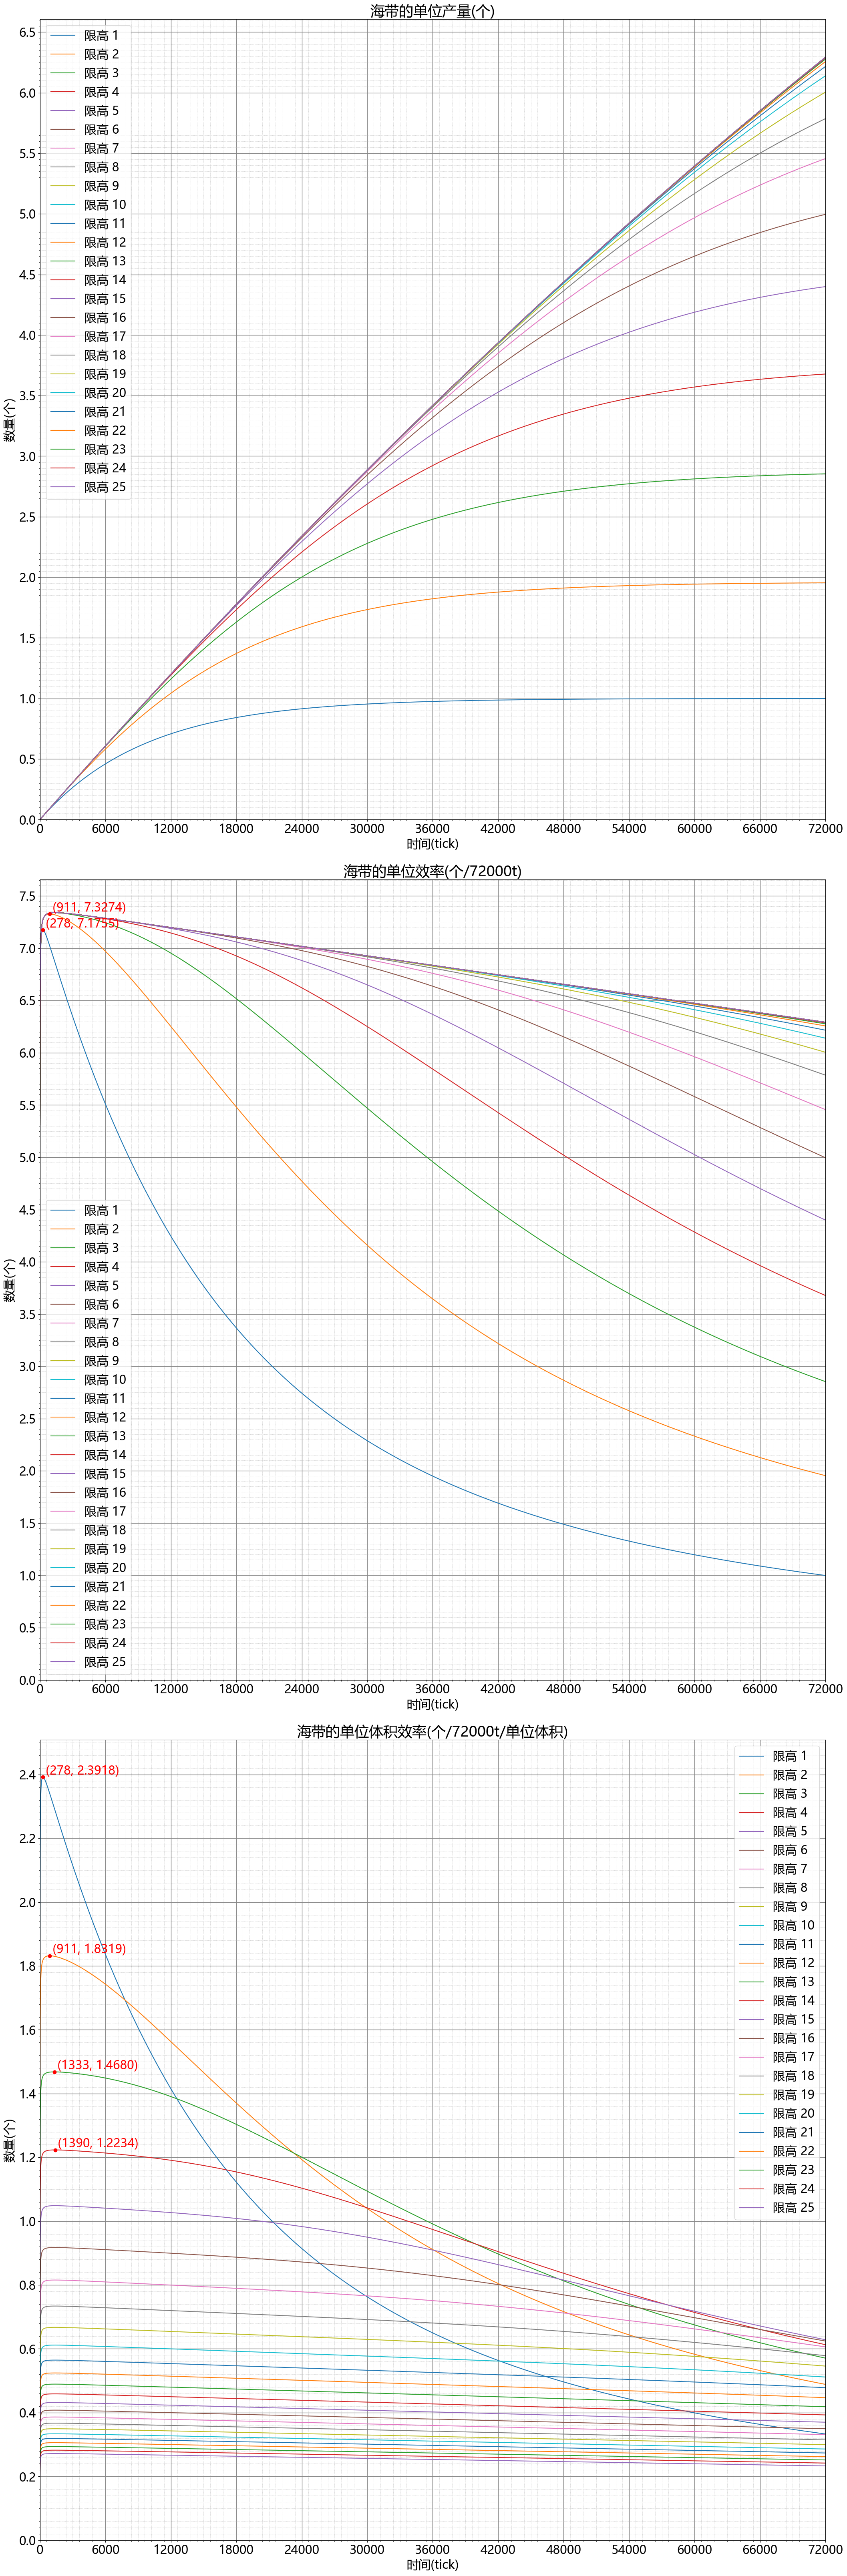

数据已画图导出为图像


In [23]:
# 3. 画图

# 3.1.1 找极值点函数
def find_extrema(data, rel_tol=1e-12):
    extrema_indices = []
    for i in range(1, len(data) - 1): # 遍历数据，跳过第一个和最后一个元素，因为它们没有足够的邻值进行比较
        if not math.isclose(data[i], data[i - 1], rel_tol=rel_tol) and \
        not math.isclose(data[i], data[i + 1], rel_tol=rel_tol):# 检查当前值与相邻值的接近性
            if (data[i] > data[i - 1] and data[i] > data[i + 1]) or \
            (data[i] < data[i - 1] and data[i] < data[i + 1]): # 判断是否为极值点
                extrema_indices.append(i)
    return extrema_indices

# 3.1.2 # 计算最合适的坐标系网格的固定间隔
def get_ideal_interval(range_value, target_lines, factor_list):
    ideal_interval = range_value / target_lines # 计算理想间隔
    order_of_magnitude = 10 ** int(np.floor(np.log10(ideal_interval))) # 计算理想间隔的数量级(为10的幂次)
    order_of_magnitude_expand = [order_of_magnitude / 10, order_of_magnitude, order_of_magnitude * 10] # 扩展数量级范围(增加*10与/10)
    best_interval = None # 初始化最佳间隔为None
    min_difference = float('inf') # 初始化最小差值为正无穷大
    for power in order_of_magnitude_expand:
        for factor in factor_list: # 遍历三个数量级下的 1, 2, 5 倍数候选
            interval = factor * power
            grid_count = range_value / interval # 计算该间隔的划分数
            difference = abs(grid_count - target_lines)
            if difference < min_difference: # 更新找到的最接目标近划分数的间隔
                min_difference = difference
                best_interval = interval
    return best_interval

# 3.1.3 画图设置函数
def plot_set(ax, title, xlabel, ylabel):
    x_min, x_max = 0, max(时间表)
    y_min, y_max = float('inf'), float('-inf')
    for line in ax.lines:
        y_data = line.get_ydata()
        y_min = min(y_min, min(y_data))
        y_max = max(y_max, max(y_data))
    y_min_0 = 0 if y_min >= 0 else None # 如果y_min不是负数，则从原点开始画图，否则None即自动判断
    x_interval = get_ideal_interval(x_max - x_min, 12 ,[1.2, 2.4, 6.0]) # 1分钟，2分钟，5分钟
    y_interval = get_ideal_interval(y_max - y_min_0, 12 ,[1,2,5])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, max(时间表))
    ax.set_ylim(y_min_0, None)
    ax.xaxis.set_major_locator(MultipleLocator(x_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_interval/10))
    ax.yaxis.set_major_locator(MultipleLocator(y_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_interval/10))
    ax.grid(which='major', axis='x', linestyle='-', linewidth=1, color='#888888')
    ax.grid(which='minor', axis='x', linestyle=':', linewidth=0.5, color='#aaaaaa')
    ax.grid(which='major', axis='y', linestyle='-', linewidth=1, color='#888888')
    ax.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, color='#aaaaaa')
    ax.legend()

# 3.1.2 画图函数
def plot_data(ax, data, height, 标记极值的限高表):
    ax.plot(时间表, data, label=f'限高 {height}') # 绘制数据
    if height in 标记极值的限高表: # 判断是否需要标记极值点
        极值表 = find_extrema(data) # 找到极值点
        for idx in 极值表: # 在极值点处绘制散点图和注释
            ax.scatter(时间表[idx], data[idx], color='red', zorder=5)
            ax.annotate(f'({时间表[idx]}, {data[idx]:.4f})',
                        xy=(时间表[idx], data[idx]),
                        xytext=(5, 5), textcoords='offset points', fontsize= picture_inch_size, color='red')

# 3.2 画图
picture_inch_size = 图片像素尺寸 / 100 # matplotlib使用英寸参数，DPI默认为100，也就是1英寸=100像素
plt.rcParams['font.family'] = 'Microsoft YaHei' # 你得找个中英文都支持的字体，否则中文或英文字符会显示为方框
plt.rcParams['font.size'] = picture_inch_size  # 字体尺寸
fig, axs = plt.subplots(3, 1, figsize=(picture_inch_size, 3 * picture_inch_size))  # 3行1列的图标

for height_idx, height in enumerate(限高列表):
    plot_data(axs[0], 单位产量表[height_idx], height, 标记极值的限高表_单位产量图)
plot_set(axs[0], f'海带的单位产量(个)', '时间(tick)', '数量(个)')

for height_idx, height in enumerate(限高列表):
    plot_data(axs[1], 单位效率表[height_idx], height,  标记极值的限高表_单位效率图)
plot_set(axs[1], f'海带的单位效率(个/{产量放大系数}t)', '时间(tick)', '数量(个)')

for height_idx, height in enumerate(限高列表):
    plot_data(axs[2], 单位体积效率表[height_idx], height, 标记极值的限高表_单位体积效率图)
plot_set(axs[2], f'海带的单位体积效率(个/{产量放大系数}t/单位体积)', '时间(tick)', '数量(个)')

# 3.3 绘制图像并导出
plt.tight_layout()
plt.savefig(f'海带的数据图像(收割费时{收割费时}t).png', dpi=100, bbox_inches='tight')
plt.show()
print("数据已画图导出为图像")


In [22]:
# 4 数据导出到Excel表格

# 4.1 添加数据的函数
def export_to_excel(sheet_name, data_table):
    all_data = []
    time_row = ['时间'] + 时间表 #第一个为“时间”，第二个开始为具体时间
    all_data.append(time_row)
    for i, limited_height in enumerate(限高列表):
        row_data = [f'限高 {limited_height}'] # 第一个数据为限高信息
        row_data += data_table[i]  # 第二个数据开始为该时间对应的数据
        all_data.append(row_data)
    df = pd.DataFrame(all_data) # 创建 DataFrame 来存储所有数据
    df = df.T
    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

# 4.2 使用 ExcelWriter 导出数据
with pd.ExcelWriter(f'海带的数据表(收割费时{收割费时}t).xlsx', engine='openpyxl') as writer:
    export_to_excel('单位产量', 单位产量表)
    export_to_excel('单位效率', 单位效率表)
    export_to_excel('单位体积效率', 单位体积效率表)  # 确保这里使用正确的数据表变量
    column_width = 16 # 设置列宽
    for sheet_name in ['单位产量', '单位效率', '单位体积效率']:
        worksheet = writer.sheets[sheet_name]
        worksheet.freeze_panes = 'A2' # 冻结第一行
        for column in worksheet.columns: # 设置列宽
            column_letter = column[0].column_letter
            worksheet.column_dimensions[column_letter].width = column_width
print("数据已导出为Excel表格")

数据已导出为Excel表格
